# Measure average swap volume for builders and relays


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import math
import pandas as pd
from dotenv import load_dotenv
import numpy as np

import statsmodels.api as sm

from tqdm import tqdm
from pathlib import Path

from concurrent.futures import ThreadPoolExecutor
from tqdm import trange, tqdm
import numpy as np
import pandas as pd

import seaborn as sns

import sys

current_path = sys.path[0]
sys.path.append(current_path[: current_path.find("defi-measurement")] + "liquidity-distribution-history")

sys.path.append("..")

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D

# Adjust so all columns in dataframe are shown
pd.set_option("display.max_columns", None)

# Set pandas display options column width
pd.set_option("display.max_colwidth", 1000)

In [3]:
postgres_uri = os.environ["POSTGRESQL_URI"]
azure_storage_uri = os.environ["AZURE_STORAGE_CONNECTION_STRING"]

## General idea: Use ETH as a proxy for swap volume

The assumption is that most the swaps happen between ETH and something else. First, though, verify this assumption.


### How to measure


In [4]:
weth_address = "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"

From the below, we see that ~84% of transactions happen to or from ETH, so I think we can argue that it's a fair measure of swap volume.


In [19]:
total_swap_count = pd.read_sql_query(
    f"""
    SELECT COUNT(*)
    FROM swaps
    JOIN factory ON address = pool
    """,
    postgres_uri,
)["count"][0]

eth_swap_count = pd.read_sql_query(
    f"""
    SELECT COUNT(*)
    FROM swaps
    JOIN factory ON address = pool
    WHERE token0 = '{weth_address}'
        OR token1 = '{weth_address}'
    """,
    postgres_uri,
)["count"][0]

print(f"Total swap count: {total_swap_count:_}, ETH swap count: {eth_swap_count:_}")
print(f"ETH swap percentage: {eth_swap_count / total_swap_count:.2%}")

Total swap count: 25_875_662, ETH swap count: 21_708_158
ETH swap percentage: 83.89%


### Measure average volume in ETH for each block

The general approach will be to find the mean transaction volume in terms of ETH within each block.

Then, we can easily join with the `mev_boost` table and calculate the mean for each builder and relay


In [20]:
# Find the block range of the swaps that happened after MEV boost was deployed
min_max_block = pd.read_sql_query(
    f"""
    SELECT MIN(block_number), MAX(block_number)
    FROM mev_boost
    """,
    postgres_uri,
)

min_block = min_max_block["min"][0]
max_block = min_max_block["max"][0]

print(f"Min block: {min_block:_}, max block: {max_block:_}")

Min block: 15_537_940, max block: 17_959_956


In [26]:
def chunked_query(query, n_rows, chunksize=10_000):
    dfs = pd.read_sql_query(
        query,
        postgres_uri,
        chunksize=chunksize,
    )

    df = pd.concat(tqdm(dfs, total=math.ceil(n_rows / chunksize)))

    return df

In [22]:
# Get the total number of swaps that is in scope
swaps_count = pd.read_sql_query(
    f"""
    SELECT COUNT(*)
    FROM swaps
    JOIN factory ON address = pool
    WHERE (token0 = '{weth_address}'
        OR 
        token1 = '{weth_address}')
    AND swaps.block_number >= {min_block}
    AND swaps.block_number <= {max_block}
    """,
    postgres_uri,
)["count"][0]

print(f"Total swap count: {swaps_count:_}")

Total swap count: 7_091_514


In [ ]:
# Get all swaps that happened after MEV boost was deployed
# where the token pair is WETH and another token
swaps = pd.read_sql_query(
    f"""
    -- Selecting rows where token0 is wETH
    SELECT swaps.block_number AS block_number, token0 AS token_address, amount0 AS amount
    FROM swaps
    JOIN factory ON address = pool
    WHERE token0 = '{weth_address}'
    AND swaps.block_number >= {min_block}
    AND swaps.block_number <= {max_block}

    UNION ALL

    -- Selecting rows where token1 is wETH
    SELECT swaps.block_number AS block_number, token1 AS token_address, amount1 AS amount
    FROM swaps
    JOIN factory ON address = pool
    WHERE token1 = '{weth_address}'
    AND swaps.block_number >= {min_block}
    AND swaps.block_number <= {max_block}
    """,
    postgres_uri,
)

In [30]:
print(f"Got {len(swaps):_} swaps in total, across {len(swaps['block_number'].unique()):_} blocks")

Got 9_272_148 swaps in total, across 1_930_592 blocks


In [28]:
# Convert the amount to ETH from wei
swaps.amount = swaps.amount.astype(float).abs() / 1e18

In [31]:
swaps.head()

,block_number,token_address,amount
0,17577508,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0.536606
1,17578272,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.370000
2,17578589,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0.760908
3,17582383,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,4.668950
4,17579971,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,4.505060


In [33]:
# Calculate mean swap size for each block
block_mean_swap_size = swaps.groupby("block_number").amount.mean()

block_mean_swap_size

block_number
15537940     9.348220
15537941    34.401677
15537943    29.511673
15537944     0.657583
15537946    11.057775
              ...    
17863998     0.030000
17864000    13.748981
17864005     4.991950
17864008     0.958249
17864015     2.896456
Name: amount, Length: 1930592, dtype: float64

In [35]:
block_mean_swap_size.index.is_monotonic_increasing

True

### Combine the mean volume per block with the mev_boost table


In [34]:
# Get the MEV boost information for each block
mev_boost = pd.read_sql_query(
    f"""
    SELECT block_number, relay, builder
    FROM mev_boost
    """,
    postgres_uri,
)

mev_boost.head()

,date,slot,block_number,relay,builder_pubkey,proposer_pubkey,mevboost_value,builder,validator
0,2022-09-15 08:33:47,4700567,15537940,flashbots,0xa1dead01e65f0a0eee7b5170223f20c8f0cbf122eac3324d61afbdb33a8885ff8cab2ef514ac2c7698ae0d6289ef27fc,0xa606aca2180226fc69e0652134eca4c7f4a428585c1122ab99c1606a53aaf9f7970df01e570b86a3bed7731d2fcbeca5,0.283204,Flashbots,0xa606aca2180226fc69e0652134eca4c7f4a428585c1122ab99c1606a53aaf9f7970df01e570b86a3bed7731d2fcbeca5
1,2022-09-15 08:35:23,4700575,15537948,flashbots,0xa1dead01e65f0a0eee7b5170223f20c8f0cbf122eac3324d61afbdb33a8885ff8cab2ef514ac2c7698ae0d6289ef27fc,0x9489e9354f515580f6a949f69eed311eeb26b268b7448b1ad6fcd4d82d855b54b355ccf7ee1a387c40203fce05f7e47c,0.845802,Flashbots,0x9489e9354f515580f6a949f69eed311eeb26b268b7448b1ad6fcd4d82d855b54b355ccf7ee1a387c40203fce05f7e47c
2,2022-09-15 08:41:35,4700606,15537978,flashbots,0x81beef03aafd3dd33ffd7deb337407142c80fea2690e5b3190cfc01bde5753f28982a7857c96172a75a234cb7bcb994f,0x82d5ebc6c3ef5eda41dcbb1cbdfd5863ab6e4d16b1375d4be6aa242649a2283249a40ee3f8874bce808c0b48bee4e4a4,0.213524,Flashbots,stakewise
3,2022-09-15 08:59:11,4700694,15538064,flashbots,0xa1dead01e65f0a0eee7b5170223f20c8f0cbf122eac3324d61afbdb33a8885ff8cab2ef514ac2c7698ae0d6289ef27fc,0x8e7d5eed0f72cd56e547e2fabea19a65668577fd2d64dbab3f00bae18715dbcda55ed73a2309e1e24f8fd53093574f74,0.113136,Flashbots,0x8e7d5eed0f72cd56e547e2fabea19a65668577fd2d64dbab3f00bae18715dbcda55ed73a2309e1e24f8fd53093574f74
4,2022-09-15 09:05:11,4700724,15538094,flashbots,0xa1dead01e65f0a0eee7b5170223f20c8f0cbf122eac3324d61afbdb33a8885ff8cab2ef514ac2c7698ae0d6289ef27fc,0xae1426c22c5c0d91d62c5a224759f44569a0a52e6cb8a19b9033a62b57940c788409a611c8eaf55e0cc6e9ca650e2fff,0.637987,Flashbots,rocketpool


In [38]:
# Add the mean volume information to the MEV boost dataframe
mev_boost["mean_swap_size"] = mev_boost.block_number.map(block_mean_swap_size)

mev_boost.head()

,block_number,relay,builder,mean_swap_size
0,15537940,flashbots,Flashbots,9.348220
1,15537948,flashbots,Flashbots,16.189291
2,15537978,flashbots,Flashbots,8.613524
3,15538064,flashbots,Flashbots,3.298476
4,15538094,flashbots,Flashbots,37.417355


In [42]:
# Check what is the coverage of the MEV boost data
block_mean_swap_size.index.nunique(), mev_boost.block_number.nunique(), len(
    set(block_mean_swap_size.index).intersection(set(mev_boost.block_number))
)

(1930592, 2045239, 1651258)

In [44]:
# Drop the missing values from the MEV boost dataframe
len_before = len(mev_boost)
mev_boost = mev_boost.dropna()
len_after = len(mev_boost)

print(f"Dropped {len_before - len_after:_} ({(len_before - len_after) / len_before:.2%}) rows with missing values")

Dropped 603494 (0.24597870744750228) rows with missing values


#### Visualize results for relays


Text(0, 0.5, 'Mean swap size')

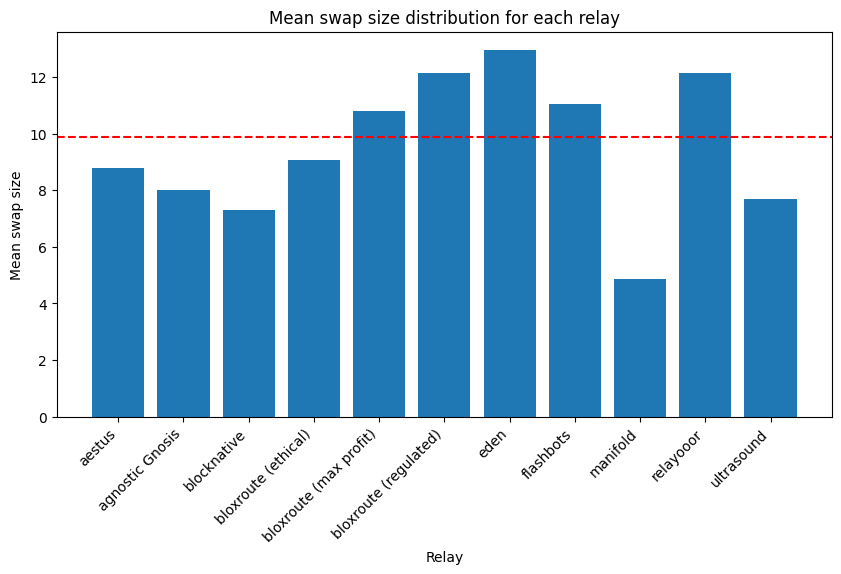

In [77]:
# Calculate the mean swap size for each relay
relay_mean_swap_size = mev_boost.groupby("relay").mean_swap_size.mean()

# Plot it as a histogram
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(relay_mean_swap_size.index, relay_mean_swap_size)

ax.axhline(mev_boost.mean_swap_size.mean(), color="red", linestyle="--")

# Rotate the x-axis labels and align them to the right
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment("right")

ax.set_title("Mean swap size distribution for each relay")
ax.set_xlabel("Relay")
ax.set_ylabel("Mean swap size")

#### Visualize results for builders


In [65]:
# Grab only the builders from the original analysis
builders = [
    "mars",
    "Bob the builder",
    "buildai.net",
    "boba-builder.com",
    "edennetwork.io",
    "Flashbots SGX",
    "builder0x69",
    "lightspeedbuilder.info",
    "beaverbuild.org",
    "Flashbots",
    "payload.de",
    "eth-builder.com",
    "BloXroute",
    "gmbit.co",
    "rsync-builder.xyz",
    "Titan Builder",
    "nfactorial.xyz",
    "Blocknative",
    "Manifold",
    "f1b.io",
    "Shared/Default",
    "I can haz block?",
    "finest artisanal blocks",
    "0x83bee51799",
    "Altruistic",
    "Geth Go",
    "It's Free Real Estate",
    "manta-builder",
]

In [66]:
# Map the builder names to something more readable
name_mapping = {
    "Gambit Labs (https://gmbit.co)": "gmbit.co",
    "BuildAI (https://buildai.net)": "buildai.net",
    "https://edennetwork.io": "edennetwork.io",
    "viva ultrasound&agnostic by 0x69": "Viva Ultrasound",
    "0x83bee51799e65130296f5d60ce7d78119578db6045c3c3631980514abae0be0f9b65fe82eb0c9a79d6d99030112c874c": "0x83bee51799",
    "https://eth-builder.com": "eth-builder.com",
}
mev_boost.builder = mev_boost.builder.replace(name_mapping)

In [69]:
mev_boost_builders = mev_boost[mev_boost.builder.isin(builders)]

mev_boost_builders.drop_duplicates(subset=["builder"]).head()

,block_number,relay,builder,mean_swap_size
0,15537940,flashbots,Flashbots,9.348220
5,15538107,eden,edennetwork.io,0.557108
15,15538306,bloxroute (max profit),Shared/Default,0.736810
43,15538613,flashbots,Geth Go,23.319068
1490,15547363,blocknative,Blocknative,94.275547


Text(0, 0.5, 'Mean swap size')

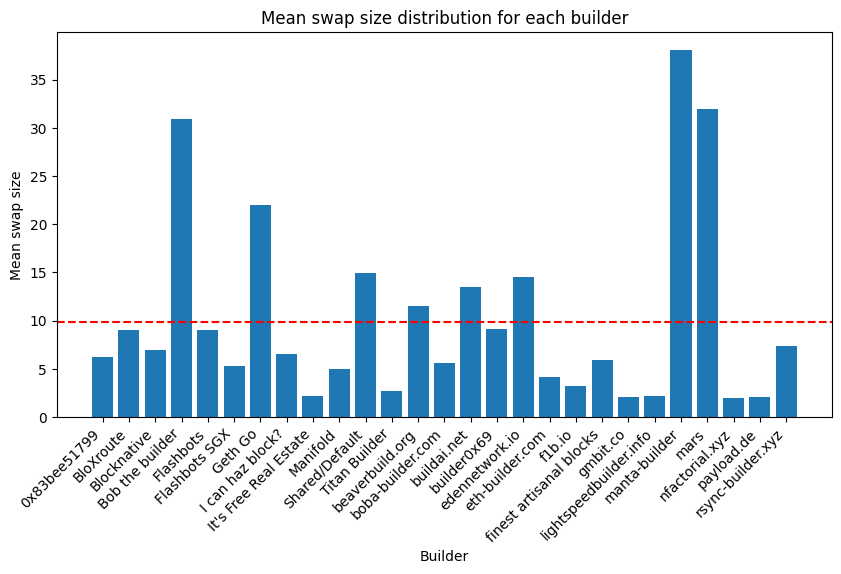

In [78]:
# Calculate the mean swap size for each builder
builder_mean_swap_size = mev_boost_builders.groupby("builder").mean_swap_size.mean()

# Plot it as a histogram
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(builder_mean_swap_size.index, builder_mean_swap_size)

# Add a line for the overall mean swap size
ax.axhline(mev_boost_builders.mean_swap_size.mean(), color="red", linestyle="--")

# Rotate the x-axis labels and align them to the right
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment("right")

ax.set_title("Mean swap size distribution for each builder")
ax.set_xlabel("Builder")
ax.set_ylabel("Mean swap size")